In [24]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'ai5-c1-group1'
!gcloud config set project {project_id}

Updated property [core/project].


In [25]:
# install faiss library
!pip install faiss-cpu

In [26]:
import os
import time
import imutils
import math
import faiss
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from IPython.display import clear_output
from google.colab import files
from imutils import paths
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [27]:
# https://www.arunprakash.org/2019/03/download-kaggle-datasets-on-google-colab.html
# http://vision.stanford.edu/aditya86/ImageNetDogs/
!gdown https://drive.google.com/uc?id=1qq758Tjsfm7Euu9ev7hSyLkMj63YC9ST  #dog breed classification dataset
!unzip --qq dogs_classification.zip

Downloading...
From: https://drive.google.com/uc?id=1qq758Tjsfm7Euu9ev7hSyLkMj63YC9ST
To: /content/dogs_classification.zip
100% 778M/778M [00:04<00:00, 173MB/s]
replace dogs_classification/imgs/n02085620-Chihuahua/n02085620_10621.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
def download_from_gdrive(file_id, file_name):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget \
    --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
    'https://docs.google.com/uc?export=download&id=$file_id' -O- | \
    sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$file_id" \
    -O $file_name && rm -rf /tmp/cookies.txt
    clear_output(wait=True)

    print("{} downloaded!".format(file_name))

In [29]:
import PIL
import PIL.Image as Image
#from PIL import Image

print(PIL.__version__)

7.1.2


In [30]:
"""

from os import listdir
from PIL import Image
   
for filename in listdir('/content/output'):
  if filename.endswith('.png'):
    try:
      img = Image.open('./'+filename) # open the image file
      img.verify() # verify that it is, in fact an image
    except (IOError, SyntaxError) as e:
      print('Bad file:', filename)

"""

"\n\nfrom os import listdir\nfrom PIL import Image\n   \nfor filename in listdir('/content/output'):\n  if filename.endswith('.png'):\n    try:\n      img = Image.open('./'+filename) # open the image file\n      img.verify() # verify that it is, in fact an image\n    except (IOError, SyntaxError) as e:\n      print('Bad file:', filename)\n\n"

In [31]:
"""

import os
from fnmatch import fnmatch
import PIL
import PIL.Image as Image
import io
import numpy as np
import os
import cv2



root = '/content/output'
pattern = "*.png"

try:
  for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            #print(os.path.join(path, name))
            input_path = os.path.join(path, name)
            #print(input_path)
            #print(type(input_path))
            byteImgIO = io.BytesIO()
            try:
                byteImg = Image.open(input_path)
                byteImg.save(byteImgIO, "PNG")
                byteImgIO.seek(0)
                byteImg = byteImgIO.read()
            except OSError as e:
                os.remove(input_path)
                continue
except OSError as e:
  print(e.error)

"""

'\n\nimport os\nfrom fnmatch import fnmatch\nimport PIL\nimport PIL.Image as Image\nimport io\nimport numpy as np\nimport os\nimport cv2\n\n\n\nroot = \'/content/output\'\npattern = "*.png"\n\ntry:\n  for path, subdirs, files in os.walk(root):\n    for name in files:\n        if fnmatch(name, pattern):\n            #print(os.path.join(path, name))\n            input_path = os.path.join(path, name)\n            #print(input_path)\n            #print(type(input_path))\n            byteImgIO = io.BytesIO()\n            try:\n                byteImg = Image.open(input_path)\n                byteImg.save(byteImgIO, "PNG")\n                byteImgIO.seek(0)\n                byteImg = byteImgIO.read()\n            except OSError as e:\n                os.remove(input_path)\n                continue\nexcept OSError as e:\n  print(e.error)\n\n'

In [32]:
IMAGES = 'dogs_classification/imgs/'
TRAIN_SAMPLES = 15548 
NUM_CLASSES = 120 # One additional label for unknown class
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [33]:
# get all image paths
image_paths = list(paths.list_images(IMAGES))

In [34]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [35]:
batch_size = 32
root_dir = 'dogs_classification/imgs/'

In [36]:
def get_model(img_width, img_height):
    base_model = EfficientNetB0(include_top=False,
                           input_shape=(img_width, img_height, 3),weights="imagenet")
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(img_width, img_height, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D(name="avg_pool")(custom_model)
    custom_model = layers.BatchNormalization()(custom_model)
    top_dropout_rate = 0.2
    custom_model = layers.Dropout(top_dropout_rate, name="top_dropout")(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [37]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, validation_split=0.2)


In [38]:
train_generator = train_datagen.flow_from_directory(root_dir,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    subset='training')
val_datagen = train_datagen.flow_from_directory(root_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), subset='validation')

Found 15548 images belonging to 120 classes.
Found 3832 images belonging to 120 classes.


In [39]:
model_finetuned = get_model(IMG_WIDTH, IMG_HEIGHT)
model_finetuned.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              metrics=['acc'])
history = model_finetuned.fit(
                              train_generator,
                              # steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
                              epochs=5, validation_data = val_datagen)

Epoch 1/5


Exception ignored in: <function ConcreteFunctionGarbageCollector.__del__ at 0x7fad202bd710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 4043, in __del__
    def __del__(self):
KeyboardInterrupt


  7/486 [..............................] - ETA: 4:04 - loss: 5.2919 - acc: 0.1384

KeyboardInterrupt: ignored

In [ ]:
#Plotting the errors and accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot((history.history['loss']), label='train loss')
plt.plot((history.history['val_loss']), color='red', label='val loss')
plt.ylabel(r'Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot((history.history['accuracy']), label='train accuracy')
plt.plot((history.history['val_accuracy']), color='red', label='val accuracy')
plt.ylabel(r'Accuracy')
plt.legend()

plt.show()

In [ ]:
for layers in model_finetuned.layers[-15:]:
  layers.trainable = True

In [ ]:
# Compiling the model
model_finetuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Training the model
history = model_finetuned.fit(train_generator,
                              steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
                              epochs=5, validation_data = val_datagen)

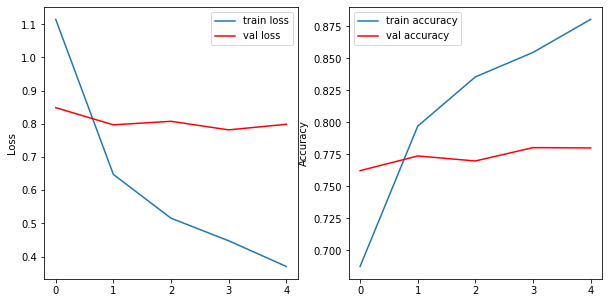

In [40]:
#Plotting the errors and accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot((history.history['loss']), label='train loss')
plt.plot((history.history['val_loss']), color='red', label='val loss')
plt.ylabel(r'Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot((history.history['accuracy']), label='train accuracy')
plt.plot((history.history['val_accuracy']), color='red', label='val accuracy')
plt.ylabel(r'Accuracy')
plt.legend()

plt.show()

In [42]:
model_finetuned = tf.keras.models.load_model('./vision_model')

In [43]:
#model_finetuned.layers.pop()
model_similarity = Model(model_finetuned.input,model_finetuned.layers[-4].output)

IndexError: ignored

In [46]:
model_similarity.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________


In [47]:
# model_similarity.save('./vision_model')
# !zip -r vision_model.zip vision_model
# !gsutil cp ./vision_model.zip gs://artifacts.ai5-c1-group1.appspot.com/data

KeyboardInterrupt: ignored

In [49]:
def get_pretrained_model(name):
    if (name == 'efficientnet'):
        model = EfficientNetB0(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    else:
        print("Specified model not available")
    return model

In [50]:
model_architecture = 'efficientnet'
model = get_pretrained_model(model_architecture)

In [51]:
# transform whole dataset
batch_size = 64
root_dir = 'dogs_classification/imgs/'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list = []
feature_list = model.predict(generator, num_epochs)
end_time = time.time()

Found 19380 images belonging to 120 classes.


In [52]:
from numpy.linalg import norm

In [53]:
start_time = time.time()
feature_list_finetuned = []
feature_list_finetuned = model_similarity.predict(generator, num_epochs)
end_time = time.time()

for i, features_finetuned in enumerate(feature_list_finetuned):
    feature_list_finetuned[i] = features_finetuned / norm(features_finetuned)

feature_list_finetuned = feature_list_finetuned.reshape(num_images, -1)

print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list_finetuned.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  19380
Shape of feature_list =  (19380, 1280)
Time taken in sec =  75.97072172164917


In [54]:
import pickle

In [55]:
filenames = [root_dir + '/' + s for s in generator.filenames]

In [56]:
pickle.dump(generator.classes, open('efficientnet_finetuned_classes.pickle','wb'))
pickle.dump(feature_list_finetuned,open('efficientnet_finetuned_features.pickle', 'wb'))

In [57]:
from sklearn.neighbors import NearestNeighbors

In [58]:
ft_neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list_finetuned)

In [59]:
import random

In [60]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename,0))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image")
        else:
            ax.set_title(classname_filename(filenames[i]) +
                         " Distance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        plt.axis("off")

In [61]:
from sklearn.manifold import TSNE
import PIL
from PIL import Image

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

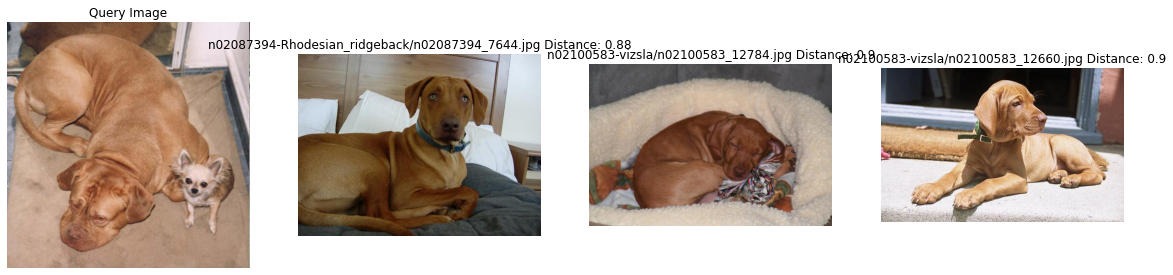

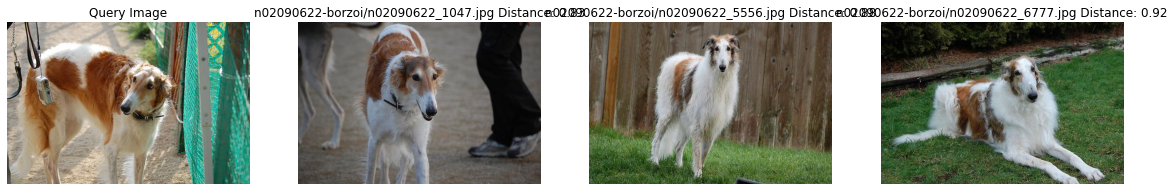

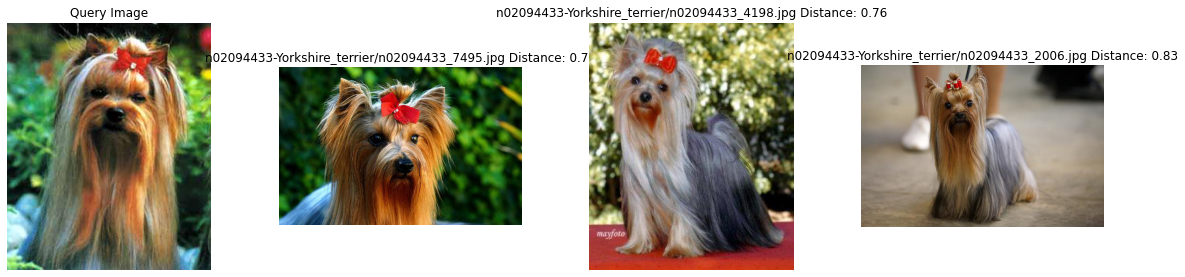

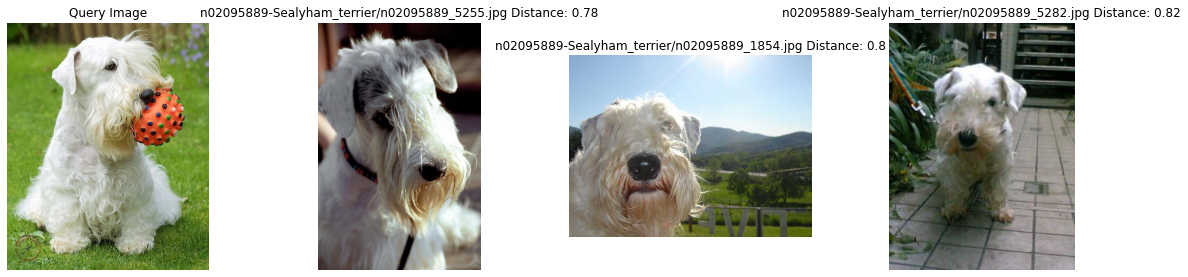

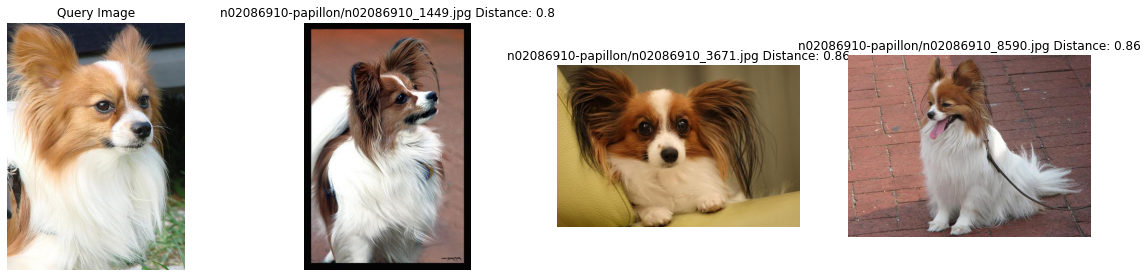

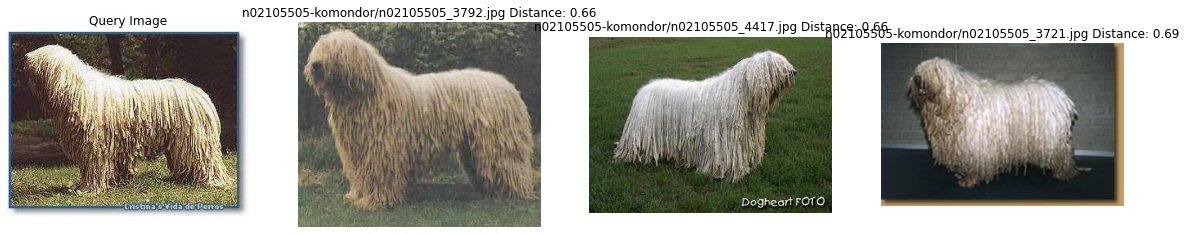

In [62]:
# visualize for a larger sample
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = ft_neighbors.kneighbors(
        [feature_list_finetuned[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [63]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model

    def extract_features(self, image):
        # prepare image to pass through the model
        image = self.prepare_image(image)
        # get the features
        features = self.model(image)
        # convert to numpy and reshape
        features = features.numpy().reshape((-1,)) # reshape to (2048,)
        return features
        
    def prepare_image(self, image):
        # preprocess using model's preprocess_input func
        image = preprocess_input(image)
        # expand the dimension: (224, 224, 3) => (1, 224, 224, 3)
        image = np.expand_dims(image, axis=0)
        return image

In [64]:
from tqdm import tqdm

# load the feature extractor model
# create an instance of FeatureExtractor class
fe = FeatureExtractor(model_finetuned)

# get all the image paths
image_paths = paths.list_images(IMAGES)
print(image_paths)
# open the output index file for writing
output = open("features_subset", "w")

added_ids = []
start = time.time()
for image_path in tqdm(image_paths):
    # extract the image ID
    # and load the image
    imageID = image_path.split("/")[3]
    if imageID not in added_ids:
        # read the image
        image = cv2.imread(image_path)

        # if image is not none: convert to RGB, resize and extract features
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            # describe the image
            features = fe.extract_features(image)

            # write the features to file
            features = [str(f) for f in features]
            output.write("%s,%s\n" % (imageID, ",".join(features)))
            added_ids.append(imageID)


# close the index file
output.close()
print("Time taken {:.2f} mins".format((time.time() - start)/60))

<generator object list_files at 0x7fabfac14ed0>


19380it [39:25,  8.19it/s]

Time taken 39.42 mins


In [65]:
IMAGES = 'dogs_classification/imgs/'

In [66]:
image_paths = list(paths.list_images(IMAGES))

In [67]:
# load the features data
df = pd.read_csv("features_subset", header=None)

In [69]:
# exclude AnimalInter-ID (first column)
features = df.iloc[:, 1:]
embeddings = features.values
# get embeddings shape
dim = embeddings.shape[1]
print("Dimension:", dim)

# convert to float32
embeddings = embeddings.astype(np.float32)

# initialize IndexFlatL2 index with our vector dimensionality
index = faiss.IndexFlatL2(dim)
# check whether an index needs to be trained using the is_trained method
print("is_trained?", index.is_trained)
# This will handle => ValueError: array is not C-contiguous
embeddings_fixed = embeddings.copy(order='C')

# load embeddings
index.add(embeddings_fixed)
print("total indices:",index.ntotal)

Dimension: 1280
is_trained? True
total indices: 19380


In [70]:
faiss.write_index(index, 'faiss_index')

In [71]:
# load the feature extractor model

# create an instance of FeatureExtractor class
fe = FeatureExtractor(model_finetuned)

In [72]:
def get_features(image_path):
    """ Load and preprocess image."""
    print('11')
    query = cv2.imread(image_path)
    print('22')
    query = cv2.resize(query, (224, 224), interpolation=cv2.INTER_AREA)
    print('33')
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    print('44')
    features = fe.extract_features(query)
    print('55')
    return features, query

def load_image(imgpath):
    print('1')
    image = cv2.imread(imgpath)
    print('2')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print('3')
    image = imutils.resize(image, width=200)
    return image

In [73]:
IMAGES = 'dogs_classification/'


In [74]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,n02099849_2050.jpg,0.320990,-0.066810,0.427068,-0.061251,0.034749,0.571092,0.091635,0.211598,0.203815,-0.161773,0.125638,-0.113323,0.292683,-0.134746,-0.113350,0.071041,-0.152624,-0.098102,0.244545,-0.080553,0.715751,0.623162,-0.116306,-0.153354,0.932717,0.026110,0.551508,-0.123271,0.491855,0.241755,-0.136063,0.463552,-0.036317,-0.109415,0.116413,-0.158091,0.007110,0.690391,0.269442,...,0.356924,0.022355,-0.110558,-0.176783,0.252184,-0.130439,0.597674,-0.017364,-0.183603,0.490826,0.043137,0.253851,-0.149496,0.736360,0.319484,-0.029553,-0.063298,0.196723,0.147441,0.225577,0.016812,0.159885,-0.117328,-0.047364,-0.011915,-0.087346,0.409483,0.098987,0.184383,0.234138,0.024672,-0.001295,0.067408,-0.097436,-0.112631,0.326662,0.051284,0.175102,0.062506,-0.011118
1,n02099849_4322.jpg,0.013791,-0.123955,0.218270,-0.080631,0.314993,0.510166,-0.147979,0.175134,-0.142719,-0.027225,-0.086821,0.194600,-0.134514,0.017761,-0.091887,0.522992,0.404423,-0.025217,0.123159,-0.135405,0.191398,0.053093,-0.042289,0.163030,0.683249,0.707374,-0.002741,0.821013,0.413237,-0.075914,-0.128690,0.160850,0.022656,-0.096729,0.322431,-0.127385,0.337980,0.493770,-0.097461,...,-0.131981,0.165698,0.016131,0.293411,0.085174,0.270997,-0.128496,0.017845,-0.147074,0.583342,-0.083896,0.535578,-0.117558,0.415964,1.205207,0.019280,0.057658,-0.054912,0.637874,0.078649,0.086248,-0.073078,-0.039723,0.184958,0.044731,-0.085838,0.007510,0.029474,0.196995,0.644397,-0.082220,0.009828,-0.047892,-0.116883,-0.115314,-0.041391,0.191201,0.102835,-0.085259,0.662260
2,n02099849_1830.jpg,0.758445,-0.118518,0.077972,-0.079047,-0.083191,0.553095,0.028846,0.553352,-0.057724,-0.076701,-0.040001,0.180879,0.053719,0.512158,0.129646,-0.121975,0.278233,0.182315,-0.157228,-0.018613,0.750603,-0.059059,-0.156927,-0.125600,1.002343,-0.008968,0.678315,0.471461,0.293026,0.839180,-0.144280,0.237635,-0.107329,0.105094,-0.015282,-0.028297,0.825553,0.001417,0.358475,...,1.095322,0.098302,-0.075198,0.044280,0.628702,0.468766,-0.086181,-0.055068,-0.162530,0.230114,-0.057230,0.275094,-0.099205,0.332260,1.704299,0.469957,0.275625,-0.119861,0.464365,0.333222,-0.119234,0.018386,0.227589,-0.104445,-0.117610,0.126114,0.369932,-0.015312,0.264657,0.355465,0.063559,0.005447,-0.079688,-0.063253,-0.135835,0.007953,-0.045178,-0.087491,0.486905,0.500523
3,n02099849_4113.jpg,-0.106198,-0.120028,0.249349,-0.040858,-0.097837,0.220334,0.229793,0.380040,-0.033692,-0.083202,0.256838,-0.106668,-0.003332,-0.076505,0.543504,-0.133546,-0.095442,-0.103626,0.059802,-0.101690,0.655057,-0.121366,-0.160888,-0.095804,0.898074,0.146774,0.302055,0.194363,0.012803,0.598371,-0.089804,0.086884,-0.188963,0.080369,0.136748,-0.103977,-0.083657,0.018508,0.445793,...,0.670277,-0.113725,-0.044095,-0.148770,0.903968,-0.109022,0.269857,-0.152109,-0.074139,0.337424,-0.043142,0.723845,-0.140240,0.999579,0.588461,-0.047884,-0.110151,-0.120429,1.031699,0.832667,0.155713,0.096839,0.013509,-0.091172,-0.082251,-0.123234,0.390384,-0.103687,-0.114821,0.500400,-0.060010,-0.047529,0.144897,-0.098376,0.037387,0.394302,0.596376,-0.094679,-0.152652,0.107063
4,n02099849_4406.jpg,0.890938,-0.151555,-0.025369,-0.113893,-0.101957,0.129436,-0.039356,0.948924,0.175010,0.428367,-0.136741,0.059498,0.176992,-0.135963,0.135561,0.015920,0.013654,-0.164421,-0.164958,-0.158692,-0.135526,-0.043830,-0.138406,-0.027752,0.638222,0.192528,0.181649,0.370234,0.134317,-0.100615,-0.190346,-0.089679,-0.199524,0.165199,-0.023805,-0.010542,-0.103510,-0.084541,0.839968,...,1.162018,-0.136253,-0.002009,0.265588,0.428416,-0.020316,-0.068483,0.341570,-0.140265,-0.073568,-0.085510,0.118494,0.116773,0.936692,0.445212,-0.161200,0.277612,0.163751,-0.117043,0.004856,-0.077450,0.2775

In [75]:
def show_similar_images(query_image_path, k):
    # load image
    print('subho1')
    print(query_image_path)
    print('subho2')
    xq, query_image = get_features(query_image_path)
    # get query image id
    # queryID = query_image_path.split(os.path.sep)[1]
    # start tracking time
    print(xq)
    print(query_image)
    start = time.time()
    D, I = index.search(np.array([xq]), k)
    print(D)
    print(I)
    print("Time taken to search: {:.2f}s".format(time.time() - start))
    # similar dogs ids
    similar_dog_ids = df[0].iloc[I[0]].values
    print(similar_dog_ids)

    # display query image
    plt.imshow(query_image)
    plt.axis("off")
    plt.title(f"Query Image", fontsize=18)
    plt.show()
    # create a figure object
    fig = plt.figure(figsize=(10, 6))
    # loop over the results and display the similar images
    for i, id in enumerate(similar_dog_ids):
        ax = fig.add_subplot(2, 5, i+1)
        img_paths = list(paths.list_images(os.path.join(IMAGES, str(id))))
        image = load_image(img_paths[0])
        plt.imshow(image)
        plt.axis('off')
        plt.title(str(id))
    plt.tight_layout()
    plt.suptitle("Similar Dogs\n", fontsize=16)
    plt.show()

In [76]:
from google.colab import files

Saving IMG_20200705_181510.jpg to IMG_20200705_181510.jpg
subho1
IMG_20200705_181510.jpg
subho2
11
22
33
44
55
[ 0.13445471 -0.15713197 -0.08901624 ...  1.2604702   0.20310849
  1.3128688 ]
[[[140 140 145]
  [141 142 146]
  [141 142 146]
  ...
  [123 121 134]
  [122 120 132]
  [124 122 133]]

 [[138 141 145]
  [140 143 146]
  [141 142 146]
  ...
  [124 122 134]
  [125 123 134]
  [125 123 134]]

 [[138 141 145]
  [140 144 147]
  [141 142 146]
  ...
  [124 122 133]
  [125 123 134]
  [124 122 133]]

 ...

 [[111 109 119]
  [123 122 121]
  [132 130 124]
  ...
  [108 101 132]
  [105  98 129]
  [102  95 126]]

 [[109 104 124]
  [111 108 125]
  [115 111 125]
  ...
  [110 103 132]
  [106  98 129]
  [103  96 127]]

 [[112 108 130]
  [112 106 129]
  [110 105 128]
  ...
  [115 105 134]
  [110 101 131]
  [107  99 130]]]
[[168.2113  169.00478 170.43588 172.88644 173.76022]]
[[15113 10574  2541    48  2258]]
Time taken to search: 0.03s
['n02109961_5732.jpg' 'n02091467_6508.jpg' 'n02088238_10183.jpg'

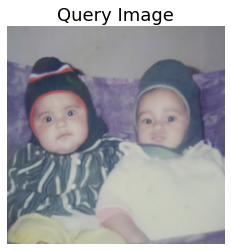

IndexError: ignored

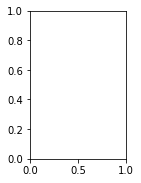

In [77]:
# upload option
uploaded = files.upload()
show_similar_images(list(uploaded.keys())[0], k=5)